In [2]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm
import copy

from utils import *
from lag_test_utils import *
from scipy.optimize import root_scalar

import matplotlib as mpl
import pandas as pd
import multiprocessing

# Set the default font and size
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16

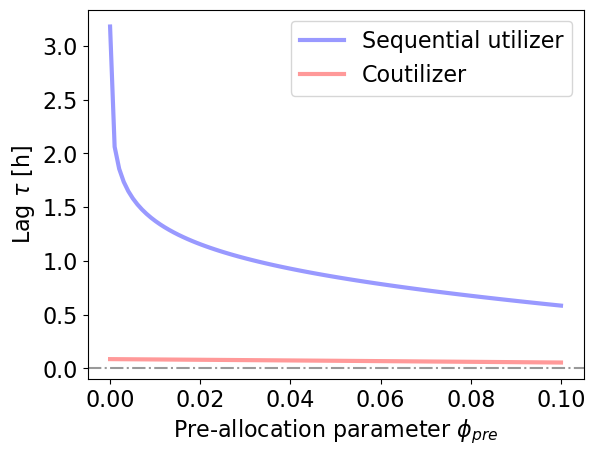

In [3]:
def TaufSeq(Rs, rho, tau0):
    nr = len(Rs)
    return tau0*log((1-(nr-1)*rho/nr)/(rho/nr))
def TaufCout(Rs, rho, tau0):
    nr = len(Rs)
    nr_pres = np.sum(Rs>0)
    if(nr_pres==nr):
        # initial lag
        return tau0*log((1/nr)/(rho/nr))
    else:
        return tau0*log((1-(nr-nr_pres)*rho/nr)/(1-(nr-nr_pres-1)*rho/nr) * (nr_pres+1)/nr_pres)

rho_list = np.linspace(1e-4, 0.4, 100)
Rs = np.array([1, 1, 1, 0])
tau0 = 0.3

tau_list = [TaufSeq(Rs, rho, tau0) for rho in rho_list]
plt.plot(rho_list/4, tau_list, color="b", alpha=0.4, linewidth=3, label="Sequential utilizer")
tau_list = [TaufCout(Rs, rho, tau0) for rho in rho_list]
plt.plot(rho_list/4, tau_list, color="r", alpha=0.4, linewidth=3, label="Coutilizer")

plt.axhline(0, color="k", alpha=0.4, linestyle="-.")
plt.xlabel("Pre-allocation parameter $\\phi_{pre}$")
plt.ylabel("Lag $\\tau$ [h]")
if(max(tau_list)>5):
    plt.ylim(0, 5)
plt.legend()
plt.show()

In [66]:
T_dilute = 24
STEADY_CRIT = 1e-6
MAX_CYCLE = 5e3
MIN_RHO = 1e-200
gmean, gsigma, gC, R, D = 0.5, 0.1, 1.0, 4, 100
tau_init_dist = lambda x: 3.0
tau_0_dist = lambda x: np.random.uniform(0.2, 0.4)

def GeneratePool(N, rho):
    # generate all species
    Nseq, Ncout = N, N
    g_seq = generate_g(Nseq, R, gmean, gsigma)
    g_seq = generate_g(Nseq, R, gmean, gsigma)
    permutations = list(itertools.permutations(list(range(1, R+1))))
    pref_list = np.array(random.choices(permutations, k=Nseq))
    col = np.argmax(g_seq, axis=1) # find column in g where it's the largest
    for row_i, row in enumerate(pref_list):
        index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
        row[0], row[index] = row[index], row[0]
    g_cout = generate_g(Ncout, R, gmean, gsigma)
    species_list = []
    for i in range(Nseq):
        species_list.append(SeqUt_alt(rho=rho, g_enz=g_seq[i], gC=gC, pref_list=pref_list[i], biomass=0.01, id=i))
    for i in np.arange(Nseq, Nseq+Ncout):
        species_list.append(CoUt_alt(rho=rho, g_enz=g_cout[i-Nseq], gC=gC, biomass=0.01, id=i))
    # find the 8 best species to be ranked at the top of invasion list
    # in order to accelerate the simulation
    for spc in species_list:
        spc.GetEating(np.ones(4))
    def get_top_n(lst, f, g, y, N=4):
        # Filter the list by condition g(x) = y
        filtered_lst = [x for x in lst if g(x) == y]
        # Sort the filtered list by f(x) in descending order
        sorted_lst = sorted(filtered_lst, key=f, reverse=True)
        return sorted_lst[:N]
    new_species_list = []
    # best diaux for 4 res
    for i in range(R): 
        new_species_list.extend(get_top_n(species_list[:Nseq], f=lambda x: x.GetGrowthRate(), 
                                          g = lambda x: x.pref[0], y=i+1, N=1))
    # 4 best cout on 1st niche
    new_species_list.extend(get_top_n(species_list[Nseq:], f=lambda x: x.GetGrowthRate(),
                                        g = lambda x: 1, y=1, N=4))
    random.shuffle(species_list)
    random.shuffle(new_species_list)
    species_list = new_species_list + [spc for spc in species_list if spc not in new_species_list]
    # assign lags to all the species
    for species in species_list:
        tau0 = tau_0_dist(0)
        tau_init = tau_init_dist(0)
        if(species.cat=="Seq"):
            species.SetLag(tau0, TaufSeq, tau_init)
            species.b = 0.01
        else:
            species.SetLag(tau0, TaufCout, tau_init)
            species.b = 0.01
        species.RezeroLag()
    return species_list

def AssemblePool(species_list, Rs):
    b_list, id_list = [], []
    C = EcoSystem([])
    history = []
    for idx, species in enumerate(species_list):
        if(C.CheckInvade(species, D)):
            print(idx)
            C.Invade(species)
            steady = False
            count = 0
            while count < MAX_CYCLE and steady == False:
                count += 1
                C.OneCycle(Rs, T_dilute)
                b_list.append(C.last_cycle['bs'][-1])
                id_list.append(C.last_cycle['ids'])
                if(len(b_list)>1 and len(b_list[-1])==len(b_list[-2])):
                    b_diff = np.abs((b_list[-1]-b_list[-2])/b_list[-1])
                    if(np.max(b_diff)<STEADY_CRIT):
                        steady = True
                C.MoveToNext(D)
            history.append([idx, C.last_cycle])
    return history

In [70]:
data_check = []

for rho in np.linspace(1e-4, 0.4, 8):
    data_check.append([])
    for i in tqdm(range(5)):
        pool0 = GeneratePool(10, rho)
        Rs = np.ones(4)
        history = AssemblePool(pool0, Rs)
        data_check[-1].append(history[-1])
    

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7


 20%|█████████                                    | 1/5 [00:25<01:41, 25.30s/it]

0
1
2
5
6


 40%|██████████████████                           | 2/5 [00:38<00:55, 18.40s/it]

0
1
2
6
7


 60%|███████████████████████████                  | 3/5 [00:40<00:21, 10.70s/it]

0
1
2
3
6
7


 80%|████████████████████████████████████         | 4/5 [00:44<00:08,  8.19s/it]

0
1
2
3
4


  0%|                                                     | 0/5 [00:00<?, ?it/s]

0
3
4
6
8


 20%|█████████                                    | 1/5 [00:04<00:19,  4.82s/it]

0
1
2
3


 40%|██████████████████                           | 2/5 [00:19<00:31, 10.43s/it]

0
1
2
3
5


 60%|███████████████████████████                  | 3/5 [00:41<00:32, 16.03s/it]

0
1
2
3
4
6


 80%|████████████████████████████████████         | 4/5 [01:01<00:17, 17.38s/it]

0
1
3
4
7


  0%|                                                     | 0/5 [00:00<?, ?it/s]

0
1
6


 20%|█████████                                    | 1/5 [00:27<01:51, 27.83s/it]

0
1
2
3
4


 40%|██████████████████                           | 2/5 [00:40<00:57, 19.13s/it]

0
1
2
4
7


 60%|███████████████████████████                  | 3/5 [00:43<00:23, 11.65s/it]

0
1
2
5
6


 80%|████████████████████████████████████         | 4/5 [01:22<00:22, 22.42s/it]

0
1
2
3


  0%|                                                     | 0/5 [00:00<?, ?it/s]

0
2
3
6


 20%|█████████                                    | 1/5 [00:02<00:10,  2.52s/it]

0
1
3
4


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.11s/it]

0
1
3
4
6


 60%|███████████████████████████                  | 3/5 [00:39<00:33, 16.92s/it]

0
1
2
5


 80%|████████████████████████████████████         | 4/5 [00:47<00:13, 13.28s/it]

0
1
4
5
6
7


  0%|                                                     | 0/5 [00:00<?, ?it/s]

0
3
5


 20%|█████████                                    | 1/5 [00:06<00:25,  6.39s/it]

0
0
1
2
5
6
7


 60%|███████████████████████████                  | 3/5 [00:24<00:16,  8.40s/it]

0
1
4
5


 80%|████████████████████████████████████         | 4/5 [00:28<00:06,  6.84s/it]

0
2


 20%|█████████                                    | 1/5 [00:00<00:03,  1.26it/s]

0
1
0
2


 40%|██████████████████                           | 2/5 [00:02<00:04,  1.38s/it]

0
1
2


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


0
2
0


  0%|                                                     | 0/5 [00:00<?, ?it/s]

0
1
6


 20%|█████████                                    | 1/5 [00:02<00:09,  2.29s/it]

0
1
2
3


 40%|██████████████████                           | 2/5 [00:27<00:46, 15.65s/it]

0
3


 60%|███████████████████████████                  | 3/5 [00:31<00:20, 10.43s/it]

0
1
2
3
7


 80%|████████████████████████████████████         | 4/5 [00:47<00:12, 12.43s/it]

0
1
5


  0%|                                                     | 0/5 [00:00<?, ?it/s]

0
1
6


 20%|█████████                                    | 1/5 [00:03<00:12,  3.20s/it]

0
3


 40%|██████████████████                           | 2/5 [00:05<00:07,  2.63s/it]

0
1
5
6


 60%|███████████████████████████                  | 3/5 [00:10<00:07,  3.72s/it]

0
3
7


 80%|████████████████████████████████████         | 4/5 [00:14<00:03,  3.76s/it]

0
1
7


100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.43s/it]


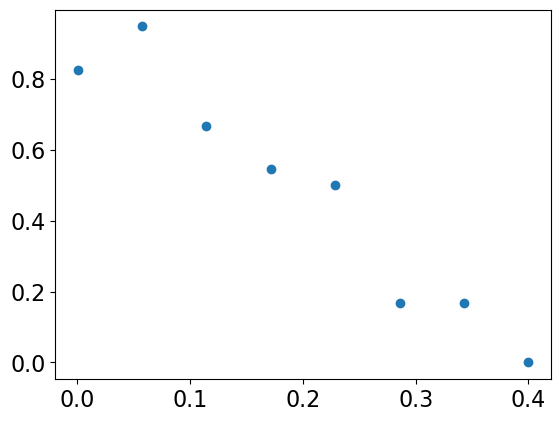

In [81]:
ids = []
for i in data_check:
    ids.append([j[1]["ids"] for j in i])
percs = []
for i in ids:
    percs.append(len([j for j in sum(i, []) if j<10])/len(sum(i, [])))
plt.scatter(np.linspace(1e-4, 0.4, 8), percs)

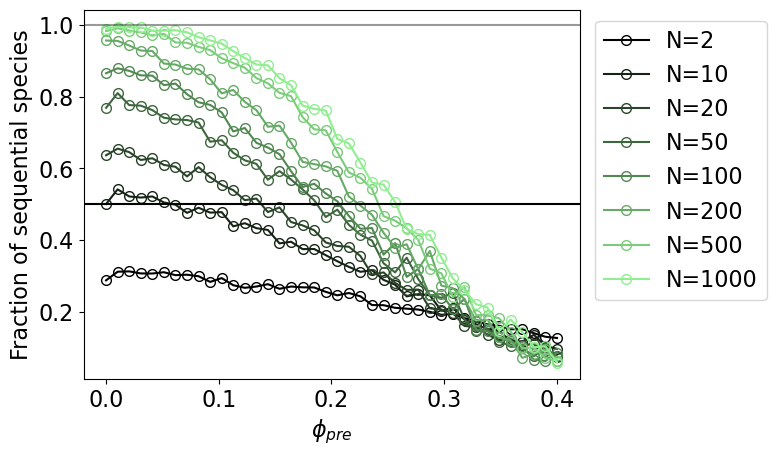

In [7]:
import pickle
import matplotlib.colors as mcolors
def generate_color_gradient(start_color, end_color, n):
    start_rgb = mcolors.hex2color(start_color)
    end_rgb = mcolors.hex2color(end_color)
    gradient = [mcolors.rgb2hex([start_rgb[j] + i * (end_rgb[j] - start_rgb[j]) / (n - 1) for j in range(3)]) for i in range(n)]
    return gradient

pool_size = 100
n_rho=40
pool_size_list = [2, 10, 20, 50, 100, 200, 500, 1000]
color_list = generate_color_gradient("#000000", "#90EE90", len(pool_size_list))

for idx, pool_size in enumerate(pool_size_list):
    fracs = []
    rholist = np.linspace(1e-4, 0.4, n_rho)
    for rho in rholist:
        data = pickle.load(open(f"../data/seq_vs_co_lag_new/rho={rho}_size={pool_size}.pkl", "rb"))["data"]
        all_ids = []
        for i in data:
            all_ids.extend(i[0][1]["ids"])
        fracs.append(len([i for i in all_ids if i<pool_size/2])/len(all_ids))
        # subset_fracs = []
        # for i in data:
        #     subset_fracs.append(len([j for j in i[0][1]["ids"] if j<pool_size/2])/len(i[0][1]["ids"]))
        # fracs.append(np.mean(subset_fracs))
    plt.plot(rholist, fracs, markerfacecolor='none', color=color_list[idx], marker='o', markersize=7, label=f"N={pool_size}")
plt.xlabel("$\\phi_{pre}$")
plt.ylabel("Fraction of sequential species")
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1))
plt.axhline(1.0, color="k", alpha=0.4)
plt.axhline(0.5, color="k")
# plt.xscale("log")
plt.savefig("figs1.pdf", bbox_inches="tight")
plt.show()